### Model and Train

In [1]:
import torch
import torch.nn.functional as F 
from torch.nn import Linear
from torch_geometric.nn import GCNConv

class GNN(torch.nn.Module):
    
    def __init__(self, dataset, feature_size):
        super(GNN, self).__init__()
        input_size = dataset[0].num_features
        output_size = 2 # binary classification
        self.conv1 = GCNConv(in_channels=input_size, out_channels=feature_size)
        self.conv2 = GCNConv(in_channels=feature_size, out_channels=output_size)

    def forward(self, x, edge_index, edge_attr=None):
            
        # First Message Passing Layer
        x = self.conv1(x=x, edge_index=edge_index, edge_weight=edge_attr)
        x = x.relu()
            
        # Second Message Passing Layer
        x = self.conv2(x=x, edge_index=edge_index, edge_weight=edge_attr)
        return x


#     def __init__(self, dataset, feature_size):
#         super(GNN, self).__init__()

#         input_size = dataset[0].num_features
#         output_size = 2
#         self.conv1 = GCNConv(in_channels=input_size, out_channels=feature_size)
#         self.conv2 = GCNConv(in_channels=feature_size, out_channels=feature_size)
#         self.d1 = torch.nn.Linear(feature_size, output_size)

#     def forward(self, x, edge_index, edge_attr=None):
#         # First Message Passing Layer
#         x = x.to(torch.float32)
#         x = self.conv1(x=x, edge_index=edge_index, edge_weight=edge_attr)
#         x = x.relu()
#         x = F.dropout(x, p=0.2, training=self.training)

#         # Second Message Passing Layer
#         x = self.conv2(x=x, edge_index=edge_index, edge_weight=edge_attr)
#         x = x.relu()
#         x = F.dropout(x, p=0.2, training=self.training)

#         # Output layer 
#         x = F.softmax(self.d1(x), dim=1)
#         return x

In [2]:
import collections
import numpy as np
import pandas as pd

import networkx as nx
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.transforms import RandomNodeSplit as nodeSplit
from torch_geometric.utils.convert import to_networkx
from tqdm import tqdm
# from model import GNN

class Train():
    def __init__(self, model, data, epochs = 10, learning_rate = 0.01):
        self.data = data
        self.model = model
        self.epochs = epochs
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr = learning_rate)
        self.loss_func = torch.nn.CrossEntropyLoss()
        self.train_network()

    def train_network(self):
        data = self.data
        optimizer = self.optimizer
        epochs = self.epochs
        
        train_losses = []
        train_accs = []
        test_losses = []
        test_accs = []

        for epoch in range(epochs + 1):
            optimizer.zero_grad()
#             output = self.model(data.x, data.edge_index)
            output = self.model(data.x, data.edge_index, data.edge_attr)
            loss = self.loss_func(output[data.train_mask], data.y[data.train_mask].long())
            loss.backward()
            optimizer.step()
            train_losses += [loss.item()]
            train_correct = torch.argmax(output[data.train_mask], dim=1) == data.y[data.train_mask]
            
#             print("Predicted label vs actual label:")
#             print(torch.argmax(output[data.train_mask], dim=1))
#             print(data.y[data.train_mask])
#             print()
            
            train_acc = int(train_correct.sum()) / int(data.train_mask.sum())
            train_accs += [train_acc]

            test_correct = torch.argmax(output[data.test_mask], dim=1) == data.y[data.test_mask]
            test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
            test_accs += [test_acc]

            print(f"Epoch {epoch + 1}/{epochs}, Train_Loss: {loss:.4f}, Train_Accuracy: {train_acc:.4f}, Test_Accuracy: {test_acc:.4f}")
        
        plt.plot(train_losses)
        plt.show()

        plt.plot(train_accs)
        plt.plot(test_accs) 
        plt.show()

### Get data

In [3]:
# Customize...
path = "../../data/processed/twitter/2021_q3.pt"

dataset = torch.load(path)
data = dataset[0]  # Get the first graph

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Data(x=[29, 64], edge_index=[2, 741], edge_attr=[741], y=[29])
Number of nodes: 29
Number of edges: 741
Average node degree: 25.55
Has isolated nodes: False
Has self-loops: True
Is undirected: True


### Split data

In [4]:
split = nodeSplit(split="train_rest", num_splits = 1, num_val = 0.0, num_test= 0.5)
masked_data = split(data)

print("Training samples:", torch.sum(masked_data.train_mask).item())
print("Validation samples:", torch.sum(masked_data.val_mask ).item())
print("Test samples:", torch.sum(masked_data.test_mask ).item())

Training samples: 15
Validation samples: 0
Test samples: 14


### Create model and train

In [5]:
model = GNN(dataset = dataset, feature_size=32)
print(model)

GNN(
  (conv1): GCNConv(64, 32)
  (conv2): GCNConv(32, 2)
)


Epoch 1/20, Train_Loss: 315.2726, Train_Accuracy: 0.2667, Test_Accuracy: 0.3571
Epoch 2/20, Train_Loss: 3.3109, Train_Accuracy: 0.7333, Test_Accuracy: 0.6429
Epoch 3/20, Train_Loss: 41.7689, Train_Accuracy: 0.7333, Test_Accuracy: 0.6429
Epoch 4/20, Train_Loss: 46.5843, Train_Accuracy: 0.7333, Test_Accuracy: 0.6429
Epoch 5/20, Train_Loss: 33.7522, Train_Accuracy: 0.7333, Test_Accuracy: 0.6429
Epoch 6/20, Train_Loss: 10.1735, Train_Accuracy: 0.7333, Test_Accuracy: 0.6429
Epoch 7/20, Train_Loss: 58.2679, Train_Accuracy: 0.2667, Test_Accuracy: 0.3571
Epoch 8/20, Train_Loss: 42.9816, Train_Accuracy: 0.2667, Test_Accuracy: 0.3571
Epoch 9/20, Train_Loss: 10.4386, Train_Accuracy: 0.7333, Test_Accuracy: 0.6429
Epoch 10/20, Train_Loss: 25.1559, Train_Accuracy: 0.7333, Test_Accuracy: 0.6429
Epoch 11/20, Train_Loss: 30.9488, Train_Accuracy: 0.7333, Test_Accuracy: 0.6429
Epoch 12/20, Train_Loss: 29.2519, Train_Accuracy: 0.7333, Test_Accuracy: 0.6429
Epoch 13/20, Train_Loss: 21.3407, Train_Accuracy:

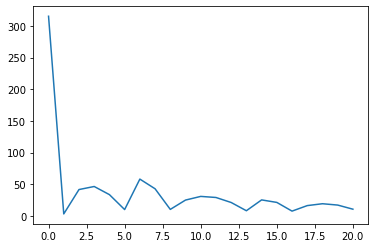

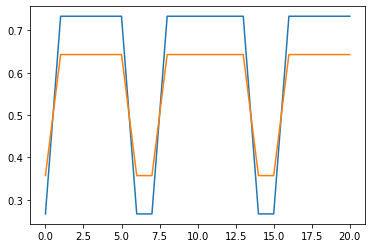

In [6]:
model = model.to(torch.float64)
masked_data.x = masked_data.x.to(torch.float64)
masked_data.y = masked_data.y.apply_(lambda x:  1 if (x > 0) else 0) # Change y into {0, 1} for binary classification
masked_data.y = masked_data.y.to(torch.float64)
masked_data.edge_attr = masked_data.edge_attr.to(torch.double)

# Customize...
training_result = Train(model = model, data = masked_data, epochs = 20, learning_rate = 0.01)